In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [3]:
# Interaction type lookup
import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
# print(interaction_dictionary)

In [106]:
events = Events("/Users/mohammed/code/CheatedRecoFile_1.root")

In [107]:
def energy(event_number):
    """needs to return energy in last X% over total energy"""
    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]        
        
        # Discarding particles with no hits
        if x.size == 0:
            continue
            
        else:
            percent = int(0.7 * len(adc))
            X = adc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(adc)
            result = Xsum / total
            
            E = np.append(E, result)
            
            # Finding the particle type
            pdg = events.mc_pdg[i]
            particleType = np.append(particleType, pdg) 
            
    return E, particleType
        

In [108]:
energy(0)

(array([0.22425398, 0.4308638 , 0.44734472, 0.66058534, 0.469403  ,
        0.65622836, 0.54536957, 1.        , 0.24436209, 1.        ,
        1.        , 0.49491915, 1.        , 0.34704295, 0.29617634,
        0.2165872 , 1.        , 0.73309821, 1.        , 0.4014191 ,
        0.36615676, 1.        , 0.28436974, 0.39836004, 0.26131824,
        0.16249129]),
 array([2212.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 2212., 2212., 2212.,    0.,    0.,
           0., 2212., 2212., 2212.,   13.,   11.,   22.,   22.]))

In [128]:
random_numbers = np.random.randint(0, max(events.event_number), 9000)

In [129]:
e = []
p = []
for i in random_numbers:
    e, p = np.append(e, energy(i)[0]), np.append(p, energy(i)[1])

In [130]:
inf = np.where(np.isinf(e))

# Create a boolean mask to keep or remove indices
keep_indices = np.ones(len(e), dtype=bool)
keep_indices[inf] = False

# Use boolean indexing to get the modified array
e = e[keep_indices]
p = p[keep_indices]

In [131]:
e.shape, p.shape

((461182,), (461182,))

In [132]:
df = pd.DataFrame({"energy": e, "particle": p})

In [133]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [134]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['energy'].values
showers = fshowers['energy'].values

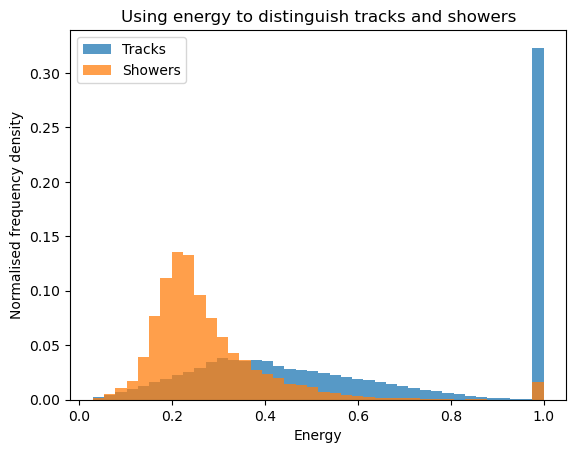

In [136]:
n_bins = 40
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using energy to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Energy")

plt.legend()
plt.show()